In [1]:
%load_ext line_profiler
%timeit

In [2]:
import sys
import os

# Adjust the path to point to your project root.
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [4]:
# from wanpy.wpythtb import *
from modules.bloch import finite_diff_coeffs
from modules import Model, Bloch, K_mesh, Wannier
from collections import defaultdict
import numpy as np
from pythtb import tb_model, wf_array
import matplotlib.pyplot as plt
from example.models import *
import scipy.integrate as scint
from scipy.linalg import polar

1D Tight-binding Model

In [5]:
def spd_chain(t, delta_E, E0=0):
    lat = [[1]]
    orbs = [[0], [0], [0]]

    model = Model(1, 1, lat, orbs)
    model.set_onsite(E0, 0)
    model.set_onsite(-E0+delta_E/2, 1)
    model.set_onsite(-E0-delta_E/2, 2)

    tss = -t
    tpp = -t
    tsp = 0.6 * t
    tdd = -0.5 * t
    tsd = 0.5 * t
    tpd = 0.3 * t

    model.set_hop(tss, 0, 0, [1])
    model.set_hop(tpp, 1, 1, [1])
    model.set_hop(tsp, 0, 1, [1])
    model.set_hop(-tsp, 1, 0, [1])
    model.set_hop(tdd, 2, 2, [1])
    model.set_hop(tpd, 2, 1, [1])
    model.set_hop(-tpd, 1, 2, [1])
    model.set_hop(tsd, 0, 2, [1])
    model.set_hop(-tsd, 2, 0, [1])

    return model

def Berry_phase(wfs, last_phase=1, dir=0):
    """
    Computes Berry phases for wavefunction arrays defined in parameter space.

    Parameters:
        wfs (np.ndarray): 
            Wavefunction array of shape [*param_arr_lens, n_orb, n_orb] where
            index -2 corresponds to the eigenvalue index and index -1 corresponds
            to amplitude.
        dir (int): 
            The direction (axis) in the parameter space along which to compute the Berry phase.

    Returns:
        phase (np.ndarray): 
            Berry phases for the specified parameter space direction.
    """
    dim_param = len(wfs.shape[:-2]) # dimensionality of parameter space
    param_axes = np.arange(0, dim_param) # parameter axes
    param_axes = np.setdiff1d(param_axes, dir) # remove direction from axes to loop
    lens = [wfs.shape[ax] for ax in param_axes] # sizes of loop directions
    idxs = np.ndindex(*lens) # index mesh
    
    phase = np.zeros((*lens, wfs.shape[-2]))
    
    for idx_set in idxs:
        # take wfs along loop axis at given idex
        sliced_wf = wfs.copy()
        for ax, idx in enumerate(idx_set):
            sliced_wf = np.take(sliced_wf, idx, axis=param_axes[ax])

        # wf now has 3 indices: [phase ax, eigval idx, orb amp]
        for n in range(sliced_wf.shape[-2]): # loop over eigval idxs
            prod = np.prod(
                [ np.vdot(sliced_wf[i, n], sliced_wf[i+1, n]) 
                for i in range(sliced_wf.shape[0]-1) ] )
            prod *= np.vdot(sliced_wf[-1, n], sliced_wf[0, n]*last_phase)
            phase[idx_set][n] = -np.angle(prod)

    return phase


def fd(U_k, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(U_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(U_k, shift=-s, axis=0)

    v = fd_sum / (dk_mu)
    return v

In [6]:
delta_E = 4
t_triv = 0.35
t_top = 1.3

sp_model_triv = spd_chain(t_triv, delta_E)
sp_model_top = spd_chain(t_top, delta_E)

In [7]:
bloch_wfs_sp = Bloch(sp_model_top, 1000)
bloch_wfs_sp.solve_model()
u_nk_sp = bloch_wfs_sp.get_states()["Cell periodic"]
psi_nk_sp = bloch_wfs_sp.get_states()["Bloch"]

Berry_phase(u_nk_sp)

array([-0.05072307,  0.02435845,  0.02635887])

In [8]:
state_idx = np.arange(1)
loop_states = [u_n[state_idx] for u_n in u_nk_sp]
# loop_states.append(u_nk[0, state_idx] * np.exp(-2j * np.pi * orb_vecs[:, 0]))
loop_states.append(u_nk_sp[0][state_idx])
loop_states = np.array(loop_states)
# loop_states = loop_states[:, None,:]
print(loop_states.shape)

winding = bloch_wfs_sp.berry_loop(loop_states, evals=True) / np.pi
print(winding)

(1001, 1, 3)
[-0.01614566]


# Testing note derivations with spd model

In [9]:
def chain(t, delta, lmbd):
    lat = [[1]]
    orb = [[0],[1/3],[2/3]]
    model = Model(1, 1, lat,orb)
    model.set_hop(t, 0, 1, [0])
    model.set_hop(t, 1, 2, [0])
    model.set_hop(t, 2, 0, [1])
    onsite_0 = -delta*np.cos(2.0*np.pi*(lmbd-0.0/3.0))
    onsite_1 = -delta*np.cos(2.0*np.pi*(lmbd-1.0/3.0))
    onsite_2 = -delta*np.cos(2.0*np.pi*(lmbd-1.5/3.0))
    model.set_onsite([onsite_0, onsite_1, onsite_2])

    return model

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

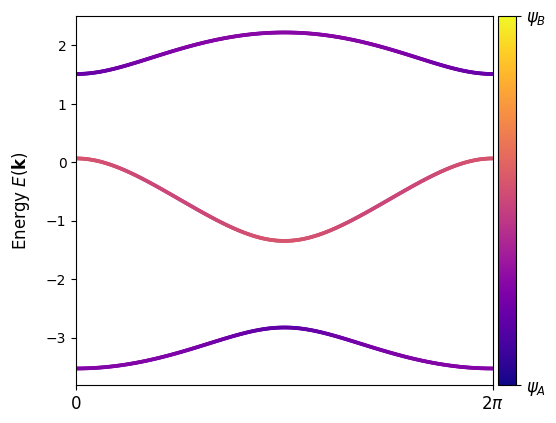

In [10]:
# delta_E = 5
# t = 2
# spd_model = spd_chain(t, delta_E)

t = -1.3
delta = 2.0
lmbd = 0.3
model = chain(t, delta, lmbd)

orb_vecs = model.get_orb_vecs()

k_path = [0, 1]
k_label = [0, r"$2\pi$"]
model.plot_bands(k_path=k_path, k_label=k_label, nk=500, cmap='plasma', proj_orb_idx=[2])

In [11]:
nk = 50000
dk = 1/nk
dk_cart = 2*np.pi / nk
kpts = np.linspace(0, 1, nk, endpoint=False)[:, None]
print(1/nk, kpts[1]-kpts[0])

# Velocity matrix
v_mu = model.get_velocity(kpts)[0]

# Bloch class
bloch_wfs = Bloch(model, nk)
bloch_wfs.solve_model()
u_nk_sp = bloch_wfs.get_states()["Cell periodic"]
psi_nk_sp = bloch_wfs.get_states()["Bloch"]
energies = bloch_wfs.energies

bphase = Berry_phase(u_nk_sp, last_phase= np.exp(-2j * np.pi * orb_vecs[:, 0]))#/ np.pi

print(bphase)
print(sum(bphase[:2]))
print(np.allclose(psi_nk_sp, u_nk_sp)) # All orbitals at origin of home cell (no phase in psi)

2e-05 [2.e-05]
[ 2.41436976 -2.05311481 -0.36125494]
0.3612549445290263
False


In [12]:
# Occupied (lower two) and conduction (last) bands
u_occ, psi_occ = u_nk_sp[:, :2, :], psi_nk_sp[:, :2, :]
u_con, psi_con = u_nk_sp[:, -1, :][:, None, :], psi_nk_sp[:, -1, :][:, None, :]

E_occ, E_con = energies[:, :2], energies[:, -1][:, None]

# Bloch class for occupied bands
bloch_occ = Bloch(model, nk)
bloch_occ.set_wfs(psi_occ, cell_periodic=True)

# Bloch class for conduction bands
bloch_con = Bloch(model, nk)
bloch_con.set_wfs(psi_con, cell_periodic=True)

$S_{nm}(k) = \langle \psi_{nk} | g_{m} \rangle $, $\rightarrow S = V \Sigma W^{\dagger}$, $\rightarrow U(k) = V W^{\dagger}$

In [13]:
def get_trial_wfs(tf_list, norb, nspin=1):
    # number of trial functions to define
    num_tf = len(tf_list)
    if nspin == 2:
        tfs = np.zeros([num_tf, norb, 2], dtype=complex)
        for j, tf in enumerate(tf_list):
            assert isinstance(tf, (list, np.ndarray)), "Trial function must be a list of tuples"
            for orb, spin, amp in tf:
                tfs[j, orb, spin] = amp
            tfs[j] /= np.linalg.norm(tfs[j])
    elif nspin == 1:
        # initialize array containing tfs = "trial functions"
        tfs = np.zeros([num_tf, norb], dtype=complex)
        for j, tf in enumerate(tf_list):
            assert isinstance(tf, (list, np.ndarray)), "Trial function must be a list of tuples"
            for site, amp in tf:
                tfs[j, site] = amp
            tfs[j] /= np.linalg.norm(tfs[j])
    return tfs 

In [14]:
# For tilde (projection) gauge states
bloch_tilde = Bloch(model, nk)

# Trial wavefunctions as delta on first and second orbital
tf_list = [[(0,0), (1,1), (2,0)], [(0,0), (1,0), (2,1)]]
twfs = get_trial_wfs(tf_list, model.n_orb, nspin=1)

# Overlap function S_nm = <psi_nk| g_m> with occupied bands
S_occ = np.einsum("...nj, mj -> ...nm", psi_occ.conj(), twfs)
S_con = np.einsum("...nj, mj -> ...nm", psi_con.conj(), twfs)

# SVD
W, Sig, Vh = np.linalg.svd(S_occ, full_matrices=True)
Sig_mat = np.einsum("...i, ij -> ...ij", Sig, np.eye(Sig.shape[-1]))
# Polar
pol =  np.array([polar(S_occ[k]) for k in range(S_occ.shape[0]) ])
U_p = pol[:, 0]
P = pol[:, 1]

# Unitary part
U_rot = W @ Vh

np.allclose(U_p, U_rot)

True

(0.0, 1.01)

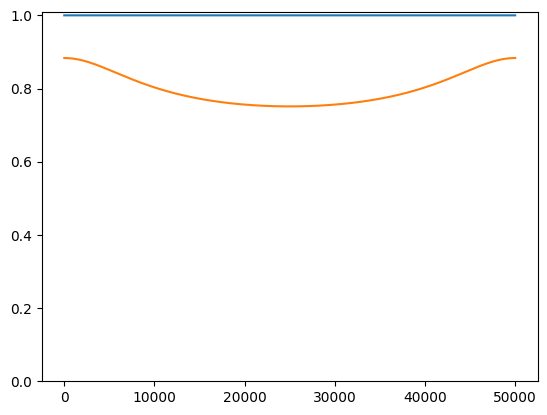

In [15]:
# Singular values
plt.plot(Sig)
plt.ylim(0,1+0.01)

$|\tilde{\psi}_{nk} \rangle = \sum_{m} U_{mn} |\psi_{mk}\rangle$

In [16]:
psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_rot, psi_occ) # shape: (*nks, states, orbs*n_spin])

bloch_tilde.set_wfs(psi_tilde, cell_periodic=False)
u_tilde = bloch_tilde.get_states()["Cell periodic"]

$|\partial_{\mu} u_{nk} \rangle$ from first order adiabatic

In [17]:
parmu_u_occ = np.zeros_like(u_occ, dtype=complex)
n_occ, n_con = u_occ.shape[-2], u_con.shape[-2]
for n in range(n_occ):
    for m in range(n_con):
        u_n_occ, u_m_con = u_occ[:, n, :], u_con[:, m, :]
        v_mu_mn = np.einsum("...j, ...jk, ...k", u_m_con.conj(), v_mu, u_n_occ)
        parmu_u_occ[:, n, :] += ( v_mu_mn / (E_occ[:, n] - E_con[:, m]) )[:, None] * u_m_con

Getting $|\partial_{\mu} \tilde{u}_{nk} \rangle$ from finite differences

In [18]:
deriv_u_tilde = fd(u_tilde, 1, order_eps=1, mode='forward')
A_tilde_fd = 1j * np.einsum("...ni, ...mj -> ...nm", u_tilde.conj(), deriv_u_tilde)

$\tilde{A}_{\mu}(k) = - \text{Im} \log U_{\mu}(k)$ where $U_{\mu}(k)$ is found from $M_{nm}^{\mu}(k) = \langle \tilde{u}_{n k} | \tilde{u}_{m k +\delta \mu} \rangle$ and $M = V \Sigma W^{\dagger}$ and $U_{\mu}(k) = VW^{\dagger}$

In [19]:
U_links_tilde = bloch_tilde.get_links(None)
U_links_en = bloch_occ.get_links(None)

# berry_conn_tilde = 1j * np.log(U_links_tilde)

eigvals, eigvecs = np.linalg.eig(U_links_tilde)
angles = -np.angle(eigvals)
angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
eigvecs_inv = np.linalg.inv(eigvecs)
berry_conn_tilde = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) / dk

# berry_conn_en = 1j * np.log(U_links_en)

eigvals, eigvecs = np.linalg.eig(U_links_en)
angles = -np.angle(eigvals)
angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
eigvecs_inv = np.linalg.inv(eigvecs)
berry_conn_en = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) / dk

print("A_mu Hermitian?", np.allclose(berry_conn_en[0], berry_conn_en[0].conj().swapaxes(-1,-2)))
print("tilde{A}_mu Hermitian?", np.allclose(berry_conn_en[0], berry_conn_en[0].conj().swapaxes(-1,-2)))

A_mu Hermitian? True
tilde{A}_mu Hermitian? True


$\phi_{\rm tot}$ unique mod $2\pi n$

In [20]:
phi_tot_til = np.sum(np.trace(berry_conn_tilde[0], axis1=-1, axis2=-2)) * dk
phi_tot_en = np.sum(np.trace(berry_conn_en[0], axis1=-1, axis2=-2)) * dk

diff = (phi_tot_en - phi_tot_til).real

print(phi_tot_en, phi_tot_til)
print(np.mod(abs(diff), 2*np.pi)-1*np.pi)
print("Unique phi mod 2pi?", np.allclose(np.mod(abs(diff), 2*np.pi), 0 ))

(8.120948547383621+8.22235548417881e-20j) (6.644440251708261+1.2480375281913994e-21j)
-1.6650843579144325
Unique phi mod 2pi? False


$U^{\dagger} \partial_{\mu} U$ is anti-Hermitian. Testing this using $U^{\dagger} \partial_{\mu} U = P^{-1} ( S^{\dagger} \partial_{\mu} S  - P \partial_{\mu} P) P^{-1}$

In [21]:
evecs_conj_tf = u_nk_sp.conj()
evecs_T_tf = u_nk_sp.swapaxes(-1,-2)  # (n_kpts, n_beta, n_state, n_state)

v_k_rot = np.matmul(
        evecs_conj_tf[None, :, :, :],  # (1, n_kpts, n_state, n_state)
        np.matmul(
            v_mu,                       # (dim_k, n_kpts, n_state, n_state)
            evecs_T_tf[None, :, :, :]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    )  

occ_idxs = np.arange(2)
cond_idxs = np.setdiff1d(np.arange(u_nk_sp.shape[-2]), occ_idxs)  # Identify conduction bands

# Compute energy denominators
delta_E = energies[..., None, :] - energies[..., :, None]
delta_E_occ_cond = np.take(np.take(delta_E, occ_idxs, axis=-2), cond_idxs, axis=-1)
delta_E_cond_occ = np.take(np.take(delta_E, cond_idxs, axis=-2), occ_idxs, axis=-1)
inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond
inv_delta_E_cond_occ_tf = 1 / delta_E_cond_occ

v_occ_cond = np.take(np.take(v_k_rot, occ_idxs, axis=-2), cond_idxs, axis=-1)
v_cond_occ = np.take(np.take(v_k_rot, cond_idxs, axis=-2), occ_idxs, axis=-1)
v_occ_cond = v_occ_cond * -inv_delta_E_occ_cond_tf
v_cond_occ = v_cond_occ * -inv_delta_E_occ_cond_tf

vhat = v_occ_cond[0] 

parmu_occ = np.sum(v_cond_occ[0], axis=-2)[:, :, None] * u_con #
parmu_S2 = v_occ_cond[0] @ S_con 
parmu_S2 += 1j* berry_conn_en[0] @ S_occ

orb_vecs = model.get_orb_vecs(Cartesian=False)
r_twf = 2*np.pi * (orb_vecs.T[:, None, :] * twfs)
rhat = np.einsum("...nj, mj -> ...nm", psi_occ.conj(), r_twf[0])
parmu_S2 += -1j * rhat

print(v_occ_cond.shape)
print(delta_E.shape)
print(S_con.shape)

(1, 50000, 2, 1)
(50000, 3, 3)
(50000, 1, 2)


In [22]:
twfs.shape

(2, 3)

In [23]:
parmu_S = np.zeros_like(S_occ, dtype=complex)
v_mu_occ_con = np.einsum("...mj, ...jk, ...nk", u_occ.conj(), v_mu, u_con)
for n in range(S_occ.shape[-1]):
    for m in range(n_occ):
        for c in range(n_con):
            v_mu_mc = v_mu_occ_con[:, m, c]
            parmu_S[:, m, n] += ( v_mu_mc / (E_occ[:, m] - E_con[:, c]) ) * S_con[:, c, n]

# NOTE: This term was missing previously
parmu_S += 1j* berry_conn_en[0] @ S_occ
parmu_S += -1j * rhat

In [24]:
parmu_S[0]

array([[ 0.37682248-3.09244948e+00j, -0.43921354-3.13053416e+00j],
       [ 0.45208701-9.91477700e+04j,  0.30840145+1.15560279e+05j]])

In [25]:
parmu_S2[0]

array([[ 0.37682248-3.09244948e+00j, -0.43921354-3.13053416e+00j],
       [ 0.45208701-9.91477700e+04j,  0.30840145+1.15560279e+05j]])

In [26]:
S_check = W.conj().swapaxes(-1,-2) @ parmu_S @ Vh.conj().swapaxes(-1,-2)

numerator = Sig[..., :, None] * S_check + Sig[..., None, :] * S_check.conj().swapaxes(-1,-2)
denominator = Sig[..., :, None] + Sig[..., None, :]
    
# Elementwise division
P_check = (numerator / denominator)
parmuP = Vh.conj().swapaxes(-1,-2) @ P_check @ Vh
PparmuP = P @ parmuP

# PparmuP = Vh @ (parmu_S.conj().swapaxes(-1,-2) @ S_occ + S_occ.conj().swapaxes(-1,-2) @ parmu_S) @ Vh.conj().swapaxes(-1,-2)
# for a in range(PparmuP.shape[-2]):
#     for b in range(PparmuP.shape[-1]):
#         PparmuP[:, a, b] *= (Sig[:, a] / (Sig[:, a] + Sig[:, b])) 

# PparmuP = Vh.conj().swapaxes(-1,-2) @ PparmuP @ Vh

In [27]:
UdagparU = np.linalg.inv(P) @ ( S_occ.conj().swapaxes(-1,-2) @ parmu_S - PparmuP ) @ np.linalg.inv(P)

print("Is U^dag dU anti-Hermitian?: ", np.amax(UdagparU.conj().swapaxes(-1,-2)+UdagparU == 0))

Is U^dag dU anti-Hermitian?:  True


In [28]:
PparmuP[0].round(5)

array([[-0.+0.03012j, -0.+0.76343j],
       [ 0.-0.69605j,  0.-0.03012j]])

In [29]:
Pparmu_P_fd = P @ fd(P, 1/nk, 5)
(Pparmu_P_fd)[0].round(5)

array([[-0.+0.03012j,  0.+0.76343j],
       [ 0.-0.69605j, -0.-0.03012j]])

In [30]:
parmu_S[10].round(4)

array([[-0.0015 -2.8526j, -0.002  -3.4101j],
       [-0.0269 -9.8544j,  0.0559+15.5545j]])

In [31]:
parmu_S2[10].round(4)

array([[-0.0015 -2.8526j, -0.002  -3.4101j],
       [-0.0269 -9.8544j,  0.0559+15.5545j]])

In [32]:
parmuS_fd = fd(S_occ, 1/nk, 9)
parmuS_fd[10].round(4)

array([[-0.0004 -1.4691j, -0.0013 -1.777j ],
       [-0.0237 -8.3437j,  0.0465+12.9666j]])

Testing whether $\tilde{A}_{\mu}(k) = U^{\dagger} A_{\mu}(k) U +  iU^{\dagger} \partial_{\mu} U$

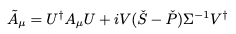

In [33]:
A_til_mu = ( 
    U_rot.conj().swapaxes(-1,-2) @ berry_conn_en[0] @ U_rot
    + 1j* Vh.conj().swapaxes(-1,-2) @ (S_check - P_check) @ np.linalg.inv(Sig_mat) @ Vh
)

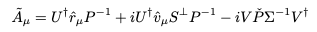

In [96]:
A_til_mu2 = (
    U_rot.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat@ S_con) @ np.linalg.inv(P) 
        - 1j*Vh.conj().swapaxes(-1,-2) @ P_check @ np.linalg.inv(Sig_mat) @ Vh
)

Showing Eq. 25 and Eq. 27 are equivalent (no Hamiltonian Berry connection in $\check{P}$)

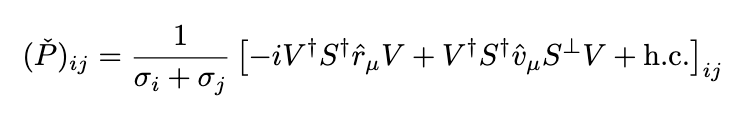

In [91]:
check_P2 = Vh @ S_occ.conj().swapaxes(-1,-2) @ (-1j*rhat + vhat @ S_con) @ Vh.conj().swapaxes(-1,-2)

for a in range(check_P2.shape[-2]):
    for b in range(check_P2.shape[-1]):
        check_P2[..., a, b] *= (1 / (Sig[..., a] + Sig[..., b]))

check_P2 = check_P2 + check_P2.conj().swapaxes(-1,-2)

In [92]:
check_P3 = W.conj().swapaxes(-1,-2) @ (-1j*rhat + vhat @ S_con) @ Vh.conj().swapaxes(-1,-2)

for a in range(check_P2.shape[-2]):
    for b in range(check_P2.shape[-1]):
        check_P3[..., a, b] *= (Sig[..., a] / (Sig[..., a] + Sig[..., b]))

check_P3 = check_P3 + check_P3.conj().swapaxes(-1,-2)

In [93]:
np.allclose(check_P2, check_P3)

True

In [38]:
A_til_mu3 = (
    U_rot.conj().swapaxes(-1,-2) @ (rhat + 1j * vhat @ S_con) @ np.linalg.inv(P) 
        - 1j*Vh.conj().swapaxes(-1,-2) @ check_P3 @ np.linalg.inv(Sig_mat) @ Vh
)

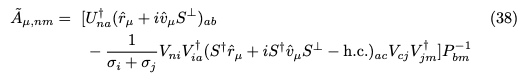

In [39]:
term =  S_occ.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat@ S_con)
term = Vh @ term @ Vh.conj().swapaxes(-1,-2)

for a in range(term.shape[-2]):
    for b in range(term.shape[-1]):
        term[..., a, b] *= (1 / (Sig[..., a] + Sig[..., b]))

term = Vh.conj().swapaxes(-1,-2) @ term @ Vh
term  = term - term.conj().swapaxes(-1,-2)

A_til_mu4 = (
    U_p.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat @ S_con)
    - term
) @ np.linalg.inv(P) 

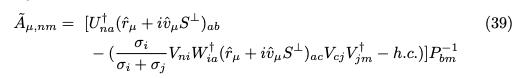

In [40]:
term = rhat + 1j * vhat @ S_con 
term = W.conj().swapaxes(-1,-2) @ term @ Vh.conj().swapaxes(-1,-2)

for a in range(term.shape[-2]):
    for b in range(term.shape[-1]):
        term[..., a, b] *= (Sig[..., a] / (Sig[..., a] + Sig[..., b]))

term = Vh.conj().swapaxes(-1,-2) @ term @ Vh
term  = term - term.conj().swapaxes(-1,-2)

A_til_mu5 = (
    U_p.conj().swapaxes(-1,-2) @ (rhat+ 1j*vhat @ S_con) 
    - term
) @ np.linalg.inv(P) 

In [41]:
print(np.allclose(check_P2, P_check))

True


In [97]:
print(np.allclose(A_til_mu, A_til_mu2))
print(np.allclose(A_til_mu, A_til_mu3))
print(np.allclose(A_til_mu, A_til_mu4))
print(np.allclose(A_til_mu, A_til_mu5))

True
True
True
True


In [138]:
A_til_mu[0].round(5)

array([[ 1.73274+0.j, -0.25377-0.j],
       [-0.25377+0.j,  5.34068-0.j]])

In [139]:
# A_til_mu6[0].round(5)

In [140]:
np.eye(2,2) - (S_occ.conj().swapaxes(-1,-2) @ S_occ)[0]

array([[0.02794354+0.j, 0.07319304+0.j],
       [0.07319304+0.j, 0.19171592+0.j]])

In [141]:
(S_con.conj().swapaxes(-1,-2) @ S_con)[0]

array([[0.02794354+0.j, 0.07319304+0.j],
       [0.07319304+0.j, 0.19171592+0.j]])

In [90]:
diff = A_til_mu3 - berry_conn_tilde[0]
print(np.amax(diff))

(4.568953206973703e-05-3.225725873743981e-13j)


In [43]:
A_tilde_ad =  U_rot.conj().swapaxes(-1,-2) @ berry_conn_en[0] @ U_rot + 1j*UdagparU

diff = A_tilde_ad - berry_conn_tilde[0]
print(np.amax(diff))

(4.5689532126580445e-05-3.291115623051523e-14j)


In [ ]:
def main(nk):
    t = -1.3
    delta = 2.0
    lmbd = 0.3
    spd_model = chain(t, delta, lmbd)

    norb = spd_model.n_orb

    dk = 1/nk
    kpts = np.linspace(0, 1, nk, endpoint=False)[:, None]

    # Velocity matrix
    v_mu = spd_model.gen_velocity(kpts)[0]

    # Bloch class
    bloch_wfs = Bloch(spd_model, nk)
    bloch_wfs.solve_model()
    u_nk_sp = bloch_wfs.get_states()["Cell periodic"]
    psi_nk_sp = bloch_wfs.get_states()["Bloch"]
    energies = bloch_wfs.energies

    # Occupied (lower two) and conduction (last) bands
    u_occ, psi_occ = u_nk_sp[:, :2, :], psi_nk_sp[:, :2, :]
    u_con, psi_con = u_nk_sp[:, -1, :][:, None, :], psi_nk_sp[:, -1, :][:, None, :]
    n_occ, n_con = u_occ.shape[-2], u_con.shape[-2]

    E_occ, E_con = energies[:, :2], energies[:, -1][:, None]

    # Bloch class for occupied bands
    bloch_occ = Bloch(spd_model, nk)
    bloch_occ.set_wfs(psi_occ, cell_periodic=True)

    # Bloch class for conduction bands
    bloch_con = Bloch(spd_model, nk)
    bloch_con.set_wfs(psi_con, cell_periodic=True)

    # # For tilde (projection) gauge states
    bloch_tilde = Bloch(spd_model, nk)

    # Trial wavefunctions as delta on first and second orbital
    tf_list = [[(0,0), (1,1), (2,0)], [(0,0), (1,0), (2,1)]]
    twfs = get_trial_wfs(tf_list, norb=norb)

    # Overlap function S_nm = <psi_nk| g_m> with occupied bands
    S_occ = np.einsum("...nj, mj -> ...nm", psi_occ.conj(), twfs)
    S_con = np.einsum("...nj, mj -> ...nm", psi_con.conj(), twfs)

    # SVD
    W, Sig, Vh = np.linalg.svd(S_occ, full_matrices=True)
    Sig_mat = np.einsum("...i, ij -> ...ij", Sig, np.eye(Sig.shape[-1]))

    # Polar
    pol =  np.array([polar(S_occ[k]) for k in range(S_occ.shape[0]) ])
    U_p = pol[:, 0]
    P = pol[:, 1]

    # Unitary part
    U_rot = W @ Vh

    ##### Berry connections from finite differences (links)
    psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_rot, psi_occ) # shape: (*nks, states, orbs*n_spin])
    bloch_tilde.set_wfs(psi_tilde, cell_periodic=False)
    u_tilde = bloch_tilde.get_states()["Cell periodic"]

    U_links_tilde = bloch_tilde.get_links(None)
    U_links_en = bloch_occ.get_links(None)

    # A_mu
    eigvals, eigvecs = np.linalg.eig(U_links_en)
    angles = -np.angle(eigvals)
    angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
    eigvecs_inv = np.linalg.inv(eigvecs)
    berry_conn_en = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) 

    # tilde{A}_mu
    eigvals, eigvecs = np.linalg.eig(U_links_tilde)
    angles = -np.angle(eigvals)
    angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
    eigvecs_inv = np.linalg.inv(eigvecs)
    # NOTE: This is what is being compared to (finite differences)
    berry_conn_tilde = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) 

    ##### Parmu S
    parmu_S = np.zeros_like(S_occ, dtype=complex)
    v_mu_occ_con = np.einsum("...mj, ...jk, ...nk", u_occ.conj(), v_mu, u_con)
    print(v_mu_occ_con.shape)
    for n in range(S_occ.shape[-1]):
        for m in range(n_occ):
            for c in range(n_con):
                # u_m_occ, u_c_con = u_occ[:, m, :], u_con[:, c, :]
                # v_mu_mc = np.einsum("...j, ...jk, ...k", u_m_occ.conj(), v_mu, u_c_con)
                v_mu_mc = v_mu_occ_con[:, m, c]
                parmu_S[:, m, n] += ( v_mu_mc / (E_occ[:, m] - E_con[:, c]) ) * S_con[:, c, n]

    ## NOTE: This term was missing previously
    parmu_S += 1j* berry_conn_en[0]*nk @ S_occ

    #### P parmu P
    mid_mat = Vh @ (parmu_S.conj().swapaxes(-1,-2) @ S_occ + S_occ.conj().swapaxes(-1,-2) @ parmu_S) @ Vh.conj().swapaxes(-1,-2)
    for a in range(mid_mat.shape[-2]):
        for b in range(mid_mat.shape[-1]):
            mid_mat[:, a, b] *= (Sig[:, a] / (Sig[:, a] + Sig[:, b])) 

    PparmuP = Vh.conj().swapaxes(-1,-2) @ mid_mat @ Vh

    #### U^dag parmu U
    UdagparU = np.linalg.inv(P) @ ( S_occ.conj().swapaxes(-1,-2) @ parmu_S - PparmuP ) @ np.linalg.inv(P)

    ##### NOTE: This is the derived equation ######
    A_tilde_ad =  U_rot.conj().swapaxes(-1,-2) @ berry_conn_en[0]*nk @ U_rot + 1j*UdagparU

    diff = A_tilde_ad - berry_conn_tilde[0]*nk
    print(np.amax(diff))

In [ ]:
%lprun -f main main(1000)

In [ ]:
nks = np.arange(10, 1000)
diffs = np.zeros(nks.shape)

A_tildes_note = []

for idx, nk in enumerate(nks):
    print(nk)

    t = -1.3
    delta = 2.0
    lmbd = 0.3
    spd_model = chain(t, delta, lmbd)

    dk = 1/nk
    kpts = np.linspace(0, 1, nk, endpoint=False)[:, None]

    # Velocity matrix
    v_mu = spd_model.gen_velocity(kpts)[0]

    # Bloch class
    bloch_wfs = Bloch(spd_model, nk)
    bloch_wfs.solve_model()
    u_nk_sp = bloch_wfs.get_states()["Cell periodic"]
    psi_nk_sp = bloch_wfs.get_states()["Bloch"]
    energies = bloch_wfs.energies

    # Occupied (lower two) and conduction (last) bands
    u_occ, psi_occ = u_nk_sp[:, :2, :], psi_nk_sp[:, :2, :]
    u_con, psi_con = u_nk_sp[:, -1, :][:, None, :], psi_nk_sp[:, -1, :][:, None, :]
    n_occ, n_con = u_occ.shape[-2], u_con.shape[-2]

    E_occ, E_con = energies[:, :2], energies[:, -1][:, None]

    # Bloch class for occupied bands
    bloch_occ = Bloch(spd_model, nk)
    bloch_occ.set_wfs(psi_occ, cell_periodic=True)

    # Bloch class for conduction bands
    bloch_con = Bloch(spd_model, nk)
    bloch_con.set_wfs(psi_con, cell_periodic=True)

    # # For tilde (projection) gauge states
    bloch_tilde = Bloch(spd_model, nk)
    WF = Wannier(spd_model, [nk])

    # Trial wavefunctions as delta on first and second orbital
    tf_list = [[(0,0), (1,1), (2,0)], [(0,0), (1,0), (2,1)]]
    twfs = WF.get_trial_wfs(tf_list)

    # Overlap function S_nm = <psi_nk| g_m> with occupied bands
    S_occ = np.einsum("...nj, mj -> ...nm", psi_occ.conj(), twfs)
    S_con = np.einsum("...nj, mj -> ...nm", psi_con.conj(), twfs)

    # SVD
    W, Sig, Vh = np.linalg.svd(S_occ, full_matrices=True)
    Sig_mat = np.einsum("...i, ij -> ...ij", Sig, np.eye(Sig.shape[-1]))

    # Polar
    pol =  np.array([polar(S_occ[k]) for k in range(S_occ.shape[0]) ])
    U_p = pol[:, 0]
    P = pol[:, 1]

    # Unitary part
    U_rot = W @ Vh

    ##### Berry connections from finite differences (links)
    psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_rot, psi_occ) # shape: (*nks, states, orbs*n_spin])
    bloch_tilde.set_wfs(psi_tilde, cell_periodic=False)
    u_tilde = bloch_tilde.get_states()["Cell periodic"]

    U_links_tilde = bloch_tilde.get_links(None)
    U_links_en = bloch_occ.get_links(None)

    # A_mu
    eigvals, eigvecs = np.linalg.eig(U_links_en)
    angles = -np.angle(eigvals)
    angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
    eigvecs_inv = np.linalg.inv(eigvecs)
    berry_conn_en = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) 

    # tilde{A}_mu
    eigvals, eigvecs = np.linalg.eig(U_links_tilde)
    angles = -np.angle(eigvals)
    angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
    eigvecs_inv = np.linalg.inv(eigvecs)
    # NOTE: This is what is being compared to (finite differences)
    berry_conn_tilde = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv) 

    ##### Parmu S
    parmu_S = np.zeros_like(S_occ, dtype=complex)
    v_mu_occ_con = np.einsum("...mj, ...jk, ...nk", u_occ.conj(), v_mu, u_con)
    for n in range(S_occ.shape[-1]):
        for m in range(n_occ):
            for c in range(n_con):
                # u_m_occ, u_c_con = u_occ[:, m, :], u_con[:, c, :]
                # v_mu_mc = np.einsum("...j, ...jk, ...k", u_m_occ.conj(), v_mu, u_c_con)
                v_mu_mc = v_mu_occ_con[:, m, c]
                parmu_S[:, m, n] += ( v_mu_mc / (E_occ[:, m] - E_con[:, c]) ) * S_con[:, c, n]

    ## NOTE: This term was missing previously
    parmu_S += 1j* berry_conn_en[0]*nk @ S_occ

    #### P parmu P
    mid_mat = Vh @ (parmu_S.conj().swapaxes(-1,-2) @ S_occ + S_occ.conj().swapaxes(-1,-2) @ parmu_S) @ Vh.conj().swapaxes(-1,-2)
    for a in range(mid_mat.shape[-2]):
        for b in range(mid_mat.shape[-1]):
            mid_mat[:, a, b] *= (Sig[:, a] / (Sig[:, a] + Sig[:, b])) 

    PparmuP = Vh.conj().swapaxes(-1,-2) @ mid_mat @ Vh

    #### U^dag parmu U
    UdagparU = np.linalg.inv(P) @ ( S_occ.conj().swapaxes(-1,-2) @ parmu_S - PparmuP ) @ np.linalg.inv(P)

    ##### NOTE: This is the derived equation ######
    A_tilde_ad =  U_rot.conj().swapaxes(-1,-2) @ berry_conn_en[0]*nk @ U_rot + 1j*UdagparU

    diff = A_tilde_ad - berry_conn_tilde[0]*nk
    diffs[idx] = np.amax(diff).real
    A_tildes_note.append(A_tilde_ad)

In [ ]:
fig, ax = plt.subplots()
ax.plot(nks, diffs)
ax.set_xlabel(r"$N_k$")
ax.set_ylabel(r"$\text{max} |\tilde{A}_{\mu}^{fd} - \tilde{A}_{\mu}^{note}|$")
ax.axhline(0, lw=1, ls='--', c='k')
plt.ylim(-0.001,0.05)